##### Figure 2: sweepfinder results

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tkr
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import re

import allel

import ingenos

In [2]:
base_path = "/overflow/dschridelab/users/rrlove/aedes/"
results_path = f"{base_path}results/"
sw_path = f"{results_path}sweepfinder/outputs/from_pine/new_dataset/"

In [3]:
chroms = ["AaegL5_1", "AaegL5_2", "AaegL5_3"]
countries = \
["Brazil", "Colombia", "USA", "Kenya", "Senegal", "Gabon"]

##### read in the data (I ran SweepFinder in overlapping 50 Mb chunks, so this is the version I previously removed the duplicate regions from and merged)

In [4]:
sw_dict = defaultdict(dict)

for chrom in chroms:
    
    for country in countries:
        
        in_path = \
        f"{sw_path}merged/{chrom}_{country}_raw_merged_deduped.121322.csv"
    
        in_df = pd.read_table(in_path)

        in_df["country"] = country
        
        in_df["chrom"] = chrom

        in_df["location"] = in_df["location"].round().map(int)

        sw_dict[chrom][country] = in_df

##### average

In [5]:
average_sw_dict = defaultdict(lambda: defaultdict(dict))

for chrom in chroms:

    for country, df in sw_dict[chrom].items():
        
        out, windows, counts = \
                allel.windowed_statistic(df["location"].astype(int), 
                                         df["LR"], np.mean, size=10000)

        average_sw_dict["10k_nonsliding"][chrom][country] = \
        (out, windows, counts)
        
for chrom in chroms:

    for country, df in sw_dict[chrom].items():
        
        out, windows, counts = \
                allel.windowed_statistic(df["location"].astype(int), 
                                         df["LR"], np.mean, size=100000)

        average_sw_dict["100k_nonsliding"][chrom][country] = \
        (out, windows, counts)


##### plot

In [6]:
#from https://stackoverflow.com/questions/27575257/how-to-divide-y-ticks-by-a-certain-number-in-matplotlib

def numfmt(x, pos):
    s = '{}'.format((x / 1000000))
    return s

yfmt = tkr.FuncFormatter(numfmt)

In [7]:
outString = ingenos.make_date_stamp(
    results_path + "popgen/sweepfinder_all_continents_with_labels", 
                                    ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/popgen/sweepfinder_all_continents_with_labels.021023.pdf'

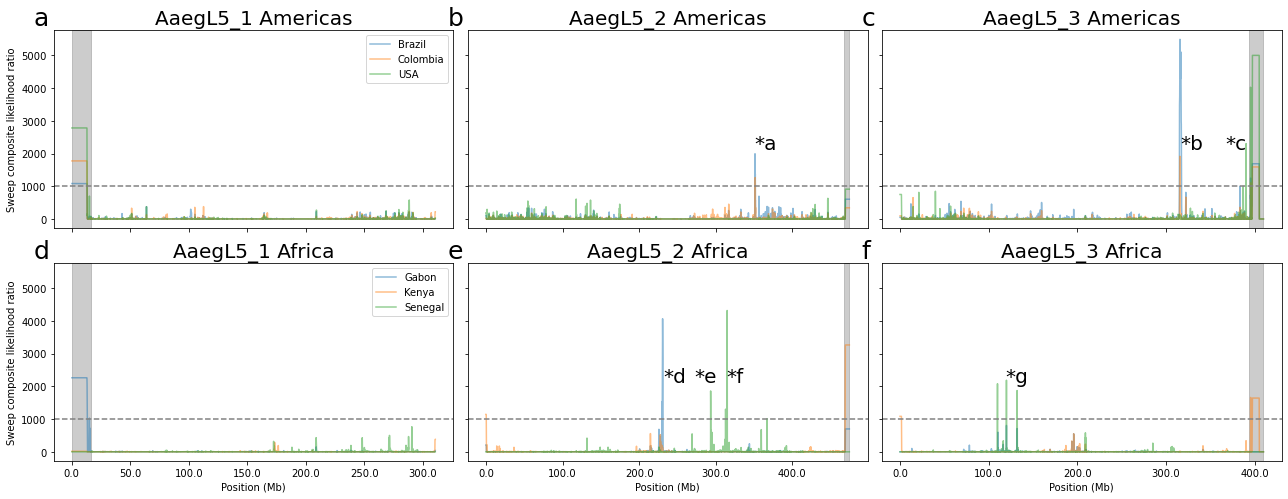

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 7), sharex="col", sharey=True)

for i, continent_pops in enumerate([["Brazil", "Colombia", "USA"], 
                                    ["Gabon", "Kenya", "Senegal"]]):
    
    for j, chrom in enumerate(chroms):
    
        ax = axes[i, j]
        
        for pop in continent_pops:
        
            out, windows, counts = average_sw_dict["100k_nonsliding"][chrom][pop]

            ax.plot(np.mean(windows, axis=1), out, label=pop, alpha = 0.5)

        if i == 0:
            ax.set_title(f"{chrom} Americas", fontsize=20)
            
        else:
            ax.set_title(f"{chrom} Africa", fontsize=20)
            
        if j == 0:
            
            ax.legend()
            ax.set_ylabel("Sweep composite likelihood ratio")
            
        if i == 1:
            
            ax.set_xlabel("Position (Mb)")
            ax.xaxis.set_major_formatter(yfmt)
        
        ax.axhline(y=1000, linestyle="--", color="grey")
        
##add regions removed at ends of chromosomes for putative technical artefacts
##chrom 1

for ax in axes[:, 0]:
    
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    
    excluded = patches.Rectangle((0, 0), 16000000, 1, color = "grey",
                                alpha = 0.4, transform = trans)
    
    ax.add_patch(excluded)
    
##chrom 2

for ax in axes[:, 1]:
    
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    
    start = 468000000
    
    chrom_max = average_sw_dict["100k_nonsliding"]["AaegL5_2"][pop][1][-1][-1]
    
    excluded = patches.Rectangle((start, 0), chrom_max - start, 1, 
                                 color = "grey",
                                alpha = 0.4, transform = trans)
    
    ax.add_patch(excluded)

##chrom 3

for ax in axes[:, 2]:
    
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    
    start = 394000000
    
    chrom_max = average_sw_dict["100k_nonsliding"]["AaegL5_3"][pop][1][-1][-1]
    
    excluded = patches.Rectangle((start, 0), chrom_max - start, 1, 
                                 color = "grey",
                                alpha = 0.4, transform = trans)
    
    ax.add_patch(excluded)

##label the seven sweeps

##sweep 1: chrom 2, ~ 350 Mb, top axis

ax = axes[0, 1]

trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    
ax.annotate("*a", (350000000, 0.4), xycoords=trans, fontsize=20)

##sweep 2: chrom 3, ~ 315 Mb, top axis

ax = axes[0, 2]

trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    
ax.annotate("*b", (316000000, 0.4), xycoords=trans, fontsize=20)
    
##sweep 3: chrom 3, ~ 390 Mb, top axis

ax = axes[0, 2]
    
trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)

ax.annotate("*c", (367000000, 0.4), xycoords=trans, fontsize=20)

##sweep 4: chrom 2, ~ 230 Mb, bottom axis

ax = axes[1, 1]

trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    
ax.annotate("*d", (231000000, 0.4), xycoords=trans, fontsize=20)

##sweep 5: chrom 2, ~ 295 Mb, bottom axis

ax = axes[1, 1]

trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    
ax.annotate("*e", (272000000, 0.4), xycoords=trans, fontsize=20)

##sweep 6: chrom 2, ~ 305 Mb, bottom axis

ax = axes[1, 1]

trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    
ax.annotate("*f", (314000000, 0.4), xycoords=trans, fontsize=20)
    
##sweep 7: chrom 3, ~ 120 Mb, bottom axis

ax = axes[1, 2]

trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    
ax.annotate("*g", (119000000, 0.4), xycoords=trans, fontsize=20)

plt.tight_layout()

##add panel labels
for i, ax in enumerate(axes.flatten()):
    label = ["a","b","c","d","e","f"][i]
    ax.text(x=-0.05, y=1.025, s=label, 
            transform=ax.transAxes, fontsize=25)

#plt.savefig(outString, bbox_inches="tight")